In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
saife245_english_premier_league_path = kagglehub.dataset_download('saife245/english-premier-league')

print('Data source import complete.')


100%|██████████| 1.12M/1.12M [00:00<00:00, 43.1MB/s]

Extracting files...


Data source import complete.


### Importing the dataset

import pandas as pd
This imports the Pandas library, It allows us to work efficiently with data tables using DataFrame and Series structures.

import matplotlib.pyplot as plt, It provides functions to create various types of charts like line plots, bar charts, scatter plots, etc.

import numpy as np, It is mainly used for numerical computations and working with arrays and matrices.

import seaborn as sns, It offers advanced plotting functions for visualizing relationships and patterns in data with better default aesthetics.

from datetime import datetime as dt, allowing us to parse, format, and manipulate date and time values. It is aliased as dt for convenience.

import itertools, provides functions that create iterators for efficient looping. It's useful for creating combinations, permutations, and other iterator-based tasks.

%matplotlib inline
This is a Jupyter/Colab-specific magic command. It ensures that all Matplotlib plots are displayed directly within the notebook cells instead of in separate windows.

In [3]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime as dt
import itertools

%matplotlib inline

This code defines the file path for the datasets, lists the seasons to be included, and then reads each season's data from a CSV file into a list of pandas DataFrames.

In [4]:
# Define the folder path
folder = saife245_english_premier_league_path + '/Datasets/'

# Define the file names for the seasons
seasons = [
    '2000-01', '2001-02', '2002-03', '2003-04', '2004-05',
    '2005-06', '2006-07', '2007-08', '2008-09', '2009-10',
    '2010-11', '2011-12', '2012-13', '2013-14', '2014-15',
    '2015-16', '2016-17', '2017-18'
]

# Read all CSV files into a list of DataFrames
raw_data = [pd.read_csv(f'{folder}{season}.csv') for season in seasons]

In [5]:
# Columns we want to keep
columns_req = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']

# Extract only the required columns from each season's DataFrame
playing_statistics = [df[columns_req] for df in raw_data]


**GOALS SCORED AND CONCEDED AT THE END OF MATCHWEEK, ARRANGED BY TEAMS AND MATCHWEEK**

In [6]:
# Function to calculate cumulative goals scored per matchweek
def get_goals_scored(playing_stat):
    # Initialize a dictionary where each team will have a list of goals scored per match
    teams = {team: [] for team in playing_stat['HomeTeam'].unique()}

    # Loop over each match in the dataset
    for i in range(len(playing_stat)):
        HTGS = playing_stat.iloc[i]['FTHG']  # Full Time Home Goals scored by Home Team
        ATGS = playing_stat.iloc[i]['FTAG']  # Full Time Away Goals scored by Away Team

        # Append goals scored to respective team lists
        teams[playing_stat.iloc[i].HomeTeam].append(HTGS)
        teams[playing_stat.iloc[i].AwayTeam].append(ATGS)

    # Convert the dictionary into a DataFrame with weeks as columns (1 to 38), teams as rows
    GS = pd.DataFrame(data=teams, index=range(1, 39)).T

    # Initialize matchweek 0 as 0 goals scored
    GS[0] = 0

    # Compute cumulative goals scored by each team up to each matchweek
    for i in range(2, 39):
        GS[i] = GS[i] + GS[i - 1]

    return GS


# Function to calculate cumulative goals conceded per matchweek
def get_goals_conceded(playing_stat):
    # Initialize a dictionary for each team's goals conceded per match
    teams = {team: [] for team in playing_stat['HomeTeam'].unique()}

    # Loop over each match
    for i in range(len(playing_stat)):
        ATGC = playing_stat.iloc[i]['FTHG']  # Home team goals = goals conceded by away team
        HTGC = playing_stat.iloc[i]['FTAG']  # Away team goals = goals conceded by home team

        # Append goals conceded to respective team lists
        teams[playing_stat.iloc[i].HomeTeam].append(HTGC)
        teams[playing_stat.iloc[i].AwayTeam].append(ATGC)

    # Convert dictionary into a DataFrame with weeks as columns (1 to 38), teams as rows
    GC = pd.DataFrame(data=teams, index=range(1, 39)).T

    # Initialize matchweek 0 as 0 goals conceded
    GC[0] = 0

    # Compute cumulative goals conceded by each team up to each matchweek
    for i in range(2, 39):
        GC[i] = GC[i] + GC[i - 1]

    return GC


# Main function to append cumulative stats to the playing_stat DataFrame
def get_gss(playing_stat):
    # Make a copy of the DataFrame to avoid SettingWithCopyWarning
    playing_stat = playing_stat.copy()

    # Get cumulative goals conceded and scored
    GC = get_goals_conceded(playing_stat)
    GS = get_goals_scored(playing_stat)

    # Initialize lists to store computed stats for each row/match
    HTGS, ATGS, HTGC, ATGC = [], [], [], []
    matchweek = 0  # Track which matchweek we are in

    # Loop over each match in the dataset
    for i in range(len(playing_stat)):
        ht = playing_stat.iloc[i].HomeTeam  # Get home team name
        at = playing_stat.iloc[i].AwayTeam  # Get away team name

        # Append cumulative stats up to current matchweek
        HTGS.append(GS.loc[ht][matchweek])
        ATGS.append(GS.loc[at][matchweek])
        HTGC.append(GC.loc[ht][matchweek])
        ATGC.append(GC.loc[at][matchweek])

        # Update matchweek every 10 matches (10 matches per week in EPL)
        if (i + 1) % 10 == 0:
            matchweek += 1

    # Add new columns to the dataset for each stat
    playing_stat['HTGS'] = HTGS  # Home Team Goals Scored so far
    playing_stat['ATGS'] = ATGS  # Away Team Goals Scored so far
    playing_stat['HTGC'] = HTGC  # Home Team Goals Conceded so far
    playing_stat['ATGC'] = ATGC  # Away Team Goals Conceded so far

    return playing_stat


# Apply the get_gss function to a list of playing statistics DataFrames
playing_statistics = [get_gss(df) for df in playing_statistics]

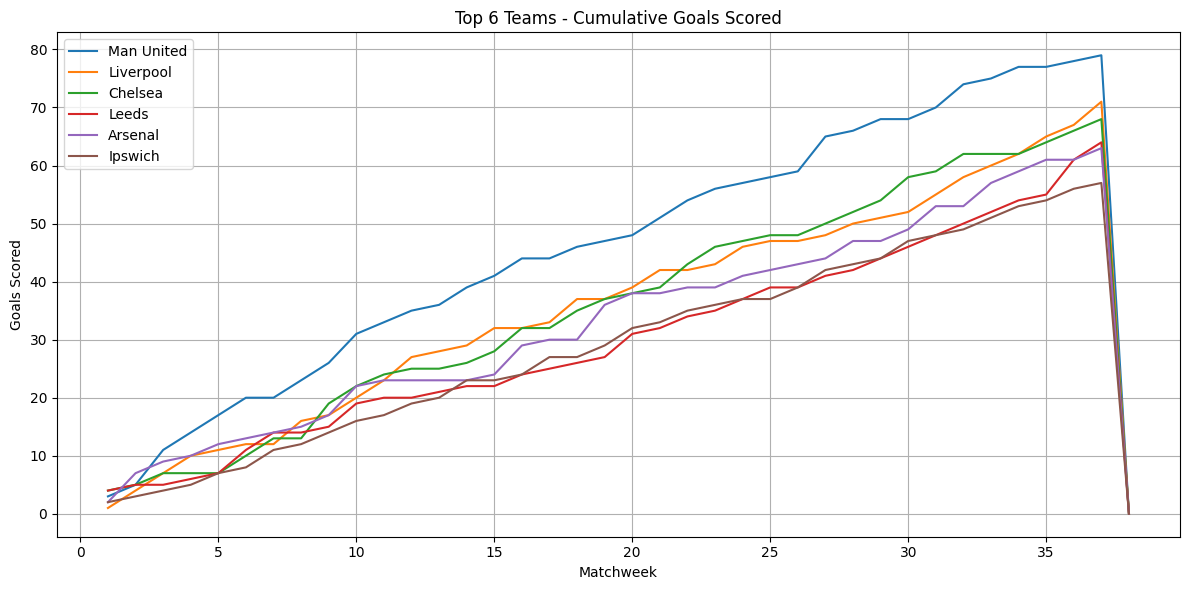

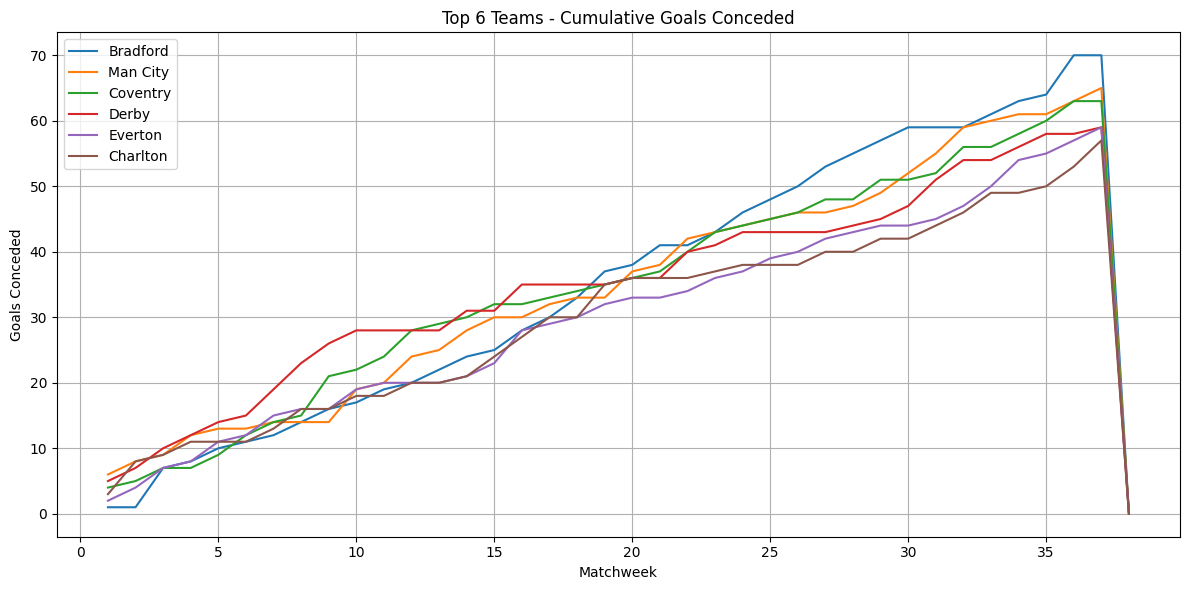

In [7]:
import matplotlib.pyplot as plt

# Choose a season (e.g., first one in your list)
df = playing_statistics[0]  # You can change the index based on your dataset

# Recalculate cumulative stats to get the dataframes GS and GC
GS = get_goals_scored(df)
GC = get_goals_conceded(df)

# Pick top 6 teams by total goals scored (last matchweek)
top_scoring_teams = GS[38].sort_values(ascending=False).head(6).index
top_conceding_teams = GC[38].sort_values(ascending=False).head(6).index  # teams conceding most

# Plot cumulative goals scored
plt.figure(figsize=(12, 6))
for team in top_scoring_teams:
    plt.plot(range(1, 39), GS.loc[team][1:39], label=team)  # matchweek 1 to 38

plt.title('Top 6 Teams - Cumulative Goals Scored')
plt.xlabel('Matchweek')
plt.ylabel('Goals Scored')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot cumulative goals conceded
plt.figure(figsize=(12, 6))
for team in top_conceding_teams:
    plt.plot(range(1, 39), GC.loc[team][1:39], label=team)  # matchweek 1 to 38

plt.title('Top 6 Teams - Cumulative Goals Conceded')
plt.xlabel('Matchweek')
plt.ylabel('Goals Conceded')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**GET RESPECTIVE POINTS**

In [9]:
# Function to convert match result to points
def get_match_points(result):
    # Win gives 3 points
    if result == 'W':
        return 3
    # Draw gives 1 point
    elif result == 'D':
        return 1
    # Loss gives 0 points
    else:
        return 0


# Function to generate raw match results (W/D/L) for each team
def get_match_results(playing_stat):
    # Initialize a dictionary for each team with an empty list
    teams = {team: [] for team in playing_stat['HomeTeam'].unique()}

    # Loop over each row/match to populate results
    for i in range(len(playing_stat)):
        result = playing_stat.iloc[i].FTR  # Match result: 'H', 'A', or 'D'

        home = playing_stat.iloc[i].HomeTeam
        away = playing_stat.iloc[i].AwayTeam

        # Append match result for each team
        if result == 'H':
            teams[home].append('W')   # Home win
            teams[away].append('L')   # Away loss
        elif result == 'A':
            teams[away].append('W')   # Away win
            teams[home].append('L')   # Home loss
        else:
            teams[home].append('D')   # Draw
            teams[away].append('D')   # Draw

    # Convert to DataFrame (weeks = columns 1-38, teams = rows)
    match_results_df = pd.DataFrame(data=teams, index=range(1, 39)).T
    return match_results_df


# Function to convert raw match results to cumulative points
def get_cumulative_points(match_results_df):
    # Apply point conversion function to each cell
    match_points = match_results_df.map(get_match_points)

    # Initialize week 0 as 0 points
    match_points[0] = 0

    # Compute cumulative points for each team up to each week
    for i in range(2, 39):
        match_points[i] = match_points[i] + match_points[i - 1]

    return match_points


# Main function to append team cumulative points to each row in the dataset
def get_team_points(playing_stat):
    # Make a copy of the DataFrame to avoid SettingWithCopyWarning
    playing_stat = playing_stat.copy()

    # Step 1: Get W/D/L for each team
    match_results = get_match_results(playing_stat)

    # Step 2: Get cumulative points for each team
    cumulative_points = get_cumulative_points(match_results)

    # Step 3: Assign cumulative points to each match row
    HTP, ATP = [], []
    matchweek = 0

    for i in range(len(playing_stat)):
        home = playing_stat.iloc[i].HomeTeam
        away = playing_stat.iloc[i].AwayTeam

        # Fetch cumulative points up to the current matchweek
        HTP.append(cumulative_points.loc[home][matchweek])
        ATP.append(cumulative_points.loc[away][matchweek])

        # Update matchweek every 10 matches
        if (i + 1) % 10 == 0:
            matchweek += 1

    # Add points columns to the DataFrame
    playing_stat['HTP'] = HTP  # Home Team Points
    playing_stat['ATP'] = ATP  # Away Team Points

    return playing_stat

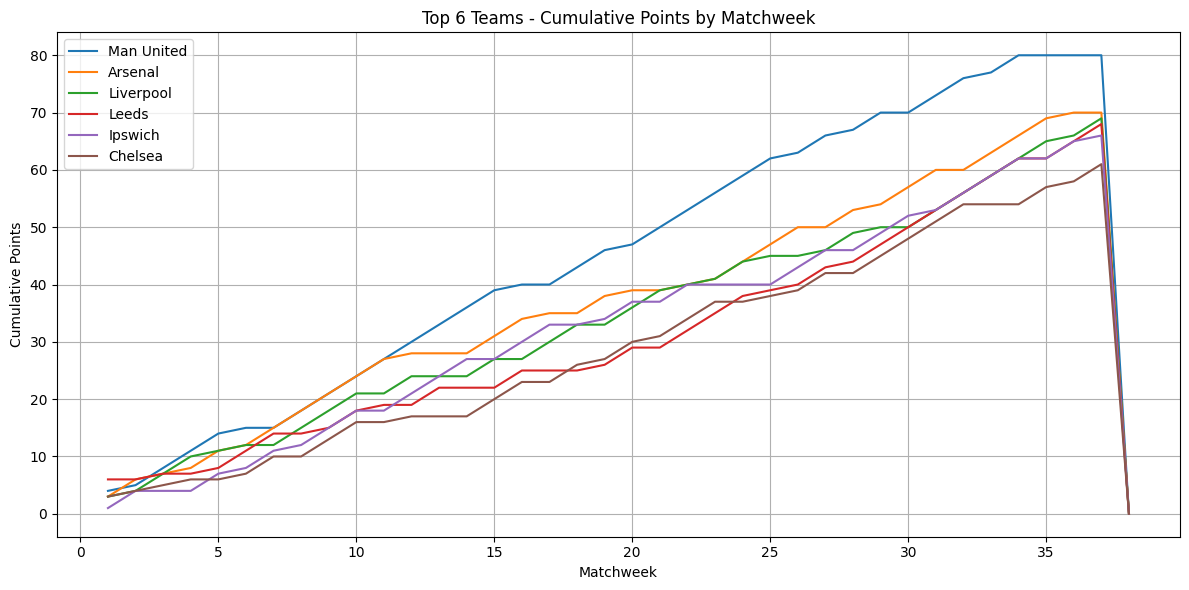

In [11]:
import matplotlib.pyplot as plt

playing_stat = get_team_points(df)  # df is dataset


# --- Step 1: Get match results and cumulative points ---
match_results_df = get_match_results(playing_stat)
cumulative_points_df = get_cumulative_points(match_results_df)

# --- Step 2: Identify top 6 teams by final points ---
top_teams = cumulative_points_df[38].sort_values(ascending=False).head(6).index

# --- Step 3: Plot cumulative points over matchweeks ---
plt.figure(figsize=(12, 6))

for team in top_teams:
    plt.plot(range(1, 39), cumulative_points_df.loc[team][1:39], label=team)  # matchweeks 1 to 38

plt.title('Top 6 Teams - Cumulative Points by Matchweek')
plt.xlabel('Matchweek')
plt.ylabel('Cumulative Points')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**GET TEAM FORM:**

In [12]:
# Function to compute rolling match results (form) for each team
def get_form_results(playing_stat):
    match_results = get_match_results(playing_stat)
    form_df = match_results.copy()

    # For each team, concatenate past match results to form a string
    for week in range(1, 39):
        for team in form_df.index:
            if week < 6:
                # Not enough matches played yet — assign 'M' for missing
                form_df.at[team, week] = 'M' * 5
            else:
                # Form is composed of the last 5 match results before this week
                form_df.at[team, week] = ''.join(match_results.loc[team][week - 5:week])

    return form_df

# Function to add form columns HM1–HM5 and AM1–AM5 to the dataset
def get_form(playing_stat):
    form_df = get_form_results(playing_stat)

    # Initialize lists to hold form info per match
    HM1, HM2, HM3, HM4, HM5 = [], [], [], [], []
    AM1, AM2, AM3, AM4, AM5 = [], [], [], [], []

    matchweek = 0

    for i in range(len(playing_stat)):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam

        # Assign 'M' if form not yet available
        if matchweek < 1:
            HM1.append('M'); HM2.append('M'); HM3.append('M'); HM4.append('M'); HM5.append('M')
            AM1.append('M'); AM2.append('M'); AM3.append('M'); AM4.append('M'); AM5.append('M')
        else:
            home_form = form_df.loc[ht][matchweek]
            away_form = form_df.loc[at][matchweek]

            HM1.append(home_form[4])
            HM2.append(home_form[3])
            HM3.append(home_form[2])
            HM4.append(home_form[1])
            HM5.append(home_form[0])

            AM1.append(away_form[4])
            AM2.append(away_form[3])
            AM3.append(away_form[2])
            AM4.append(away_form[1])
            AM5.append(away_form[0])

        # Every 10 matches = new matchweek
        if (i + 1) % 10 == 0:
            matchweek += 1

    # Add columns to DataFrame
    playing_stat['HM1'] = HM1; playing_stat['HM2'] = HM2; playing_stat['HM3'] = HM3
    playing_stat['HM4'] = HM4; playing_stat['HM5'] = HM5

    playing_stat['AM1'] = AM1; playing_stat['AM2'] = AM2; playing_stat['AM3'] = AM3
    playing_stat['AM4'] = AM4; playing_stat['AM5'] = AM5

    return playing_stat
# Apply the get_form function to all playing_stat datasets
playing_statistics = [get_form(df) for df in playing_statistics]



/tmp/ipython-input-15-3584035263.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  win_counts = match_results.applymap(lambda x: 1 if x == 'W' else 0).cumsum(axis=1)


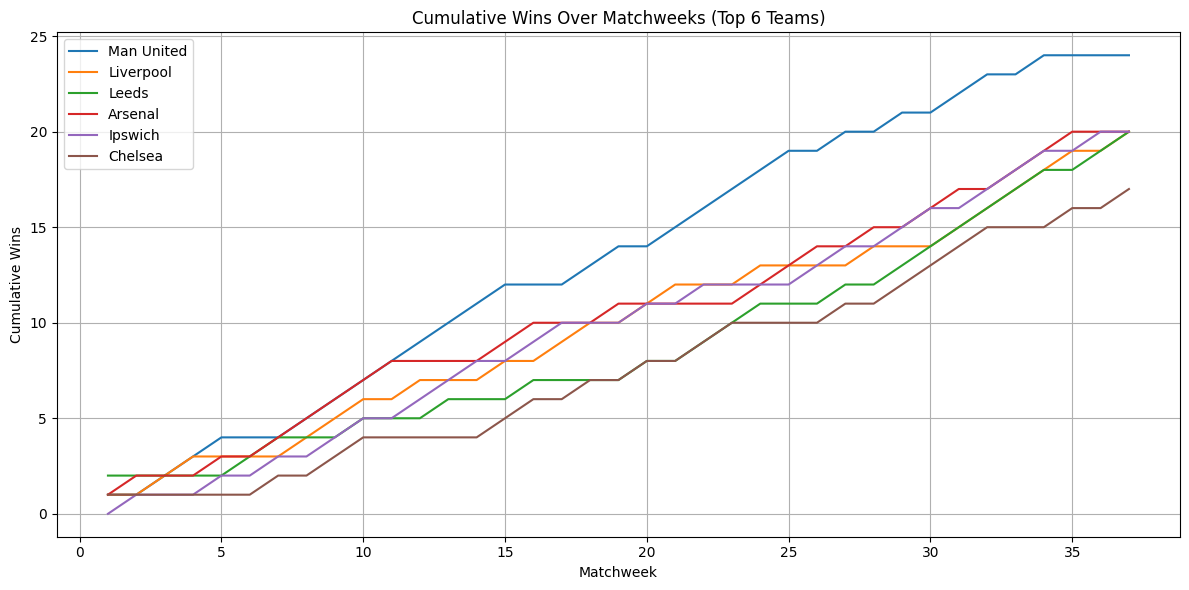

In [15]:
playing_stat = get_form(df)  # if you’re using a single DataFrame

import matplotlib.pyplot as plt

# Reuse match_results function from previous steps
match_results = get_match_results(playing_stat)

# Compute cumulative win counts per matchweek
win_counts = match_results.map(lambda x: 1 if x == 'W' else 0).cumsum(axis=1)

# Identify top 6 teams with most wins
top_teams = win_counts[38].sort_values(ascending=False).head(6).index

# Plotting
plt.figure(figsize=(12, 6))
for team in top_teams:
    plt.plot(range(1, 38), win_counts.loc[team][1:38], label=team)

plt.title("Cumulative Wins Over Matchweeks (Top 6 Teams)")
plt.xlabel("Matchweek")
plt.ylabel("Cumulative Wins")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Apply the get_gss function to a list of playing statistics DataFrames
playing_statistics = [get_gss(df) for df in playing_statistics]

# Apply the get_team_points function to all playing_stat datasets
playing_statistics = [get_team_points(df) for df in playing_statistics]

# Desired column order
cols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
        'HTGS', 'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP',
        'HM1', 'HM2', 'HM3', 'HM4', 'HM5',
        'AM1', 'AM2', 'AM3', 'AM4', 'AM5']

# Apply the column rearrangement to each playing_statistics_i
playing_statistics = [df[cols] for df in playing_statistics]

**Get MatchWeek:**

In [ ]:
# Function to add MatchWeek column (MW) based on number of matches
def get_mw(playing_stat):
    j = 1
    MatchWeek = []
    for i in range(380):  # EPL season has 380 matches
        MatchWeek.append(j)
        if ((i + 1) % 10) == 0:  # Every 10 matches = 1 week
            j += 1
    playing_stat['MW'] = MatchWeek
    return playing_stat

# Apply get_mw to all season DataFrames
playing_statistics = [get_mw(df) for df in playing_statistics]


**FINAL DATAFRAME**

In [ ]:
# Combine all playing_statistics DataFrames into one
playing_stat = pd.concat(
    playing_statistics,
    ignore_index=True
)

# Helper function to assign points from result character
def get_points(result):
    if result == 'W':
        return 3
    elif result == 'D':
        return 1
    elif result == 'L':
        return 0
    else:
        return 0  # Handle unexpected values

# Calculates total form points from a string like 'WDWLW'
def get_form_points(string):
    return sum(get_points(letter) for letter in string)

# Create home and away form strings
home_matches = [f'HM{i}' for i in range(1, 6)]
away_matches = [f'AM{i}' for i in range(1, 6)]

playing_stat['HTFormPtsStr'] = playing_stat[home_matches].agg(''.join, axis=1)
playing_stat['ATFormPtsStr'] = playing_stat[away_matches].agg(''.join, axis=1)

# Apply form points calculation
playing_stat['HTFormPts'] = playing_stat['HTFormPtsStr'].apply(get_form_points)
playing_stat['ATFormPts'] = playing_stat['ATFormPtsStr'].apply(get_form_points)

# Streak helper functions
def get_streak(string, pattern):
    return int(string.endswith(pattern))

def is_exact_streak(string, pattern):
    return int(string == pattern)

# Generate win/loss streak flags for Home and Away teams
for prefix in ['HT', 'AT']:
    form_str_col = f'{prefix}FormPtsStr'

    playing_stat[f'{prefix}WinStreak3'] = playing_stat[form_str_col].apply(lambda x: get_streak(x, 'WWW'))
    playing_stat[f'{prefix}WinStreak5'] = playing_stat[form_str_col].apply(lambda x: is_exact_streak(x, 'WWWWW'))
    playing_stat[f'{prefix}LossStreak3'] = playing_stat[form_str_col].apply(lambda x: get_streak(x, 'LLL'))
    playing_stat[f'{prefix}LossStreak5'] = playing_stat[form_str_col].apply(lambda x: is_exact_streak(x, 'LLLLL'))

# Check column names at the end
print(playing_stat.columns)

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTGS', 'ATGS',
       'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3', 'HM4', 'HM5', 'AM1',
       'AM2', 'AM3', 'AM4', 'AM5', 'MW', 'HTFormPtsStr', 'ATFormPtsStr',
       'HTFormPts', 'ATFormPts', 'HTWinStreak3', 'HTWinStreak5',
       'HTLossStreak3', 'HTLossStreak5', 'ATWinStreak3', 'ATWinStreak5',
       'ATLossStreak3', 'ATLossStreak5'],
      dtype='object')


In [ ]:
# -------------------------------------
# 1. Compute Goal Differences (GD)
# -------------------------------------
playing_stat['HTGD'] = playing_stat['HTGS'] - playing_stat['HTGC']  # Home Team Goal Difference
playing_stat['ATGD'] = playing_stat['ATGS'] - playing_stat['ATGC']  # Away Team Goal Difference

# -------------------------------------
# 2. Compute Points and Form Differences
# -------------------------------------
playing_stat['DiffPts'] = playing_stat['HTP'] - playing_stat['ATP']  # Points difference
playing_stat['DiffFormPts'] = playing_stat['HTFormPts'] - playing_stat['ATFormPts']  # Form points difference

# -------------------------------------
# 3. Scale stats by Matchweek (MW)
# -------------------------------------
# Convert MatchWeek to float (to avoid integer division)
playing_stat['MW'] = playing_stat['MW'].astype(float)

# Features to scale by matchweek
scale_cols = ['HTGD', 'ATGD', 'DiffPts', 'DiffFormPts', 'HTP', 'ATP']

# Normalize each feature by matchweek
for col in scale_cols:
    playing_stat[col] = playing_stat[col] / playing_stat['MW']

# -------------------------------------
# 4. Binary Classification: Only Home Wins vs Not Home Win
# -------------------------------------
# Convert FTR (Full Time Result) to binary class
def label_home_win(result):
    return 'H' if result == 'H' else 'NH'  # NH = Not Home Win

playing_stat['FTR'] = playing_stat['FTR'].apply(label_home_win)

# -------------------------------------
# 5. Prepare Test Set (Assuming last season is 2015-16)
# -------------------------------------
playing_stat_test = playing_stat[5700:]  # Rows 5700 onwards are test set

# -------------------------------------
# 6. Save Processed Datasets
# -------------------------------------
playing_stat.to_csv('final_dataset.csv', index=False)        # Full dataset
playing_stat_test.to_csv('test_set.csv', index=False)        # Test subset only

# -------------------------------------
# 7. Reload and Preview Dataset
# -------------------------------------
dataset = pd.read_csv('final_dataset.csv')  # Load for inspection
print(dataset.head())                       # Preview first few rows
print(dataset.columns)                      # Print column names


       Date  HomeTeam       AwayTeam  FTHG  FTAG FTR  HTGS  ATGS  HTGC  ATGC  \
0  19/08/00  Charlton       Man City     4     0   H     0     0     0     0   
1  19/08/00   Chelsea       West Ham     4     2   H     0     0     0     0   
2  19/08/00  Coventry  Middlesbrough     1     3  NH     0     0     0     0   
3  19/08/00     Derby    Southampton     2     2  NH     0     0     0     0   
4  19/08/00     Leeds        Everton     2     0   H     0     0     0     0   

   ...  HTLossStreak3  HTLossStreak5 ATWinStreak3 ATWinStreak5 ATLossStreak3  \
0  ...              0              0            0            0             0   
1  ...              0              0            0            0             0   
2  ...              0              0            0            0             0   
3  ...              0              0            0            0             0   
4  ...              0              0            0            0             0   

  ATLossStreak5 HTGD ATGD DiffPts Diff

In [ ]:
# Create a copy of the full dataset before dropping columns
dataset2 = playing_stat.copy().drop(columns=[
    'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG',       # Raw match result data
    'HTGS', 'ATGS', 'HTGC', 'ATGC',                       # Goals scored/conceded
    'HM4', 'HM5', 'AM4', 'AM5',                           # Old form memory
    'MW',                                                 # Matchweek info
    'HTFormPtsStr', 'ATFormPtsStr',                       # Form string
    'HTFormPts', 'ATFormPts',                             # Form points
    'HTWinStreak3', 'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5',
    'ATWinStreak3', 'ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5',
    'DiffPts'                                             # Points difference (already normalized)
])

# Optional: Check remaining feature names
print("Remaining features in dataset2:")
print(dataset2.keys())

# Optional: Preview the first 10 rows
print("\nPreview of dataset2:")
print(dataset2.head(10))

# --------------------------------------
# Calculate Win Rate for Home Team
# --------------------------------------

# Total number of matches
n_matches = dataset2.shape[0]

# Number of features (excluding the target variable 'FTR')
n_features = dataset2.shape[1] - 1

# Count number of home wins (where FTR == 'H')
n_homewins = len(dataset2[dataset2.FTR == 'H'])

# Calculate win rate percentage
win_rate = (n_homewins / n_matches) * 100

# Print results
print("\nMatch Statistics Summary:")
print(f"Total number of matches: {n_matches}")
print(f"Number of features: {n_features}")
print(f"Number of matches won by home team: {n_homewins}")
print(f"Win rate of home team: {win_rate:.2f}%")


Remaining features in dataset2:
Index(['FTR', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3', 'AM1', 'AM2', 'AM3', 'HTGD',
       'ATGD', 'DiffFormPts'],
      dtype='object')

Preview of dataset2:
  FTR  HTP  ATP HM1 HM2 HM3 AM1 AM2 AM3  HTGD  ATGD  DiffFormPts
0   H  0.0  0.0   M   M   M   M   M   M   0.0   0.0          0.0
1   H  0.0  0.0   M   M   M   M   M   M   0.0   0.0          0.0
2  NH  0.0  0.0   M   M   M   M   M   M   0.0   0.0          0.0
3  NH  0.0  0.0   M   M   M   M   M   M   0.0   0.0          0.0
4   H  0.0  0.0   M   M   M   M   M   M   0.0   0.0          0.0
5  NH  0.0  0.0   M   M   M   M   M   M   0.0   0.0          0.0
6   H  0.0  0.0   M   M   M   M   M   M   0.0   0.0          0.0
7   H  0.0  0.0   M   M   M   M   M   M   0.0   0.0          0.0
8   H  0.0  0.0   M   M   M   M   M   M   0.0   0.0          0.0
9   H  0.0  0.0   M   M   M   M   M   M   0.0   0.0          0.0

Match Statistics Summary:
Total number of matches: 6840
Number of features: 11
Number of matches wo

In [ ]:
# Separate dataset into features (X) and target (y)
# 'FTR' = Full Time Result: 'H' = Home Win, 'NH' = Not Home Win (as per earlier transformation)
X_all = dataset2.drop(['FTR'], axis=1)  # Drop the target column from features
y_all = dataset2['FTR']                 # Target variable

# Standardize numeric features: HTGD, ATGD, HTP, ATP
from sklearn.preprocessing import scale

# Columns to scale
scale_cols = ['HTGD', 'ATGD', 'HTP', 'ATP']

# Apply standardization (zero mean, unit variance)
X_all[scale_cols] = scale(X_all[scale_cols])

# Ensure form-related columns are strings for dummy conversion
form_cols = ['HM1', 'HM2', 'HM3', 'AM1', 'AM2', 'AM3']
X_all[form_cols] = X_all[form_cols].astype(str)

# Preprocess features: convert categorical variables to dummy variables
def preprocess_features(X):
    '''Converts categorical columns to one-hot encoded variables.'''
    output = pd.DataFrame(index=X.index)

    for col, col_data in X.items(): # Changed iteritems() to items()
        # Convert categorical data to one-hot encoded columns
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)

        # Add column(s) to output
        output = output.join(col_data)

    return output

# Apply preprocessing
X_all = preprocess_features(X_all)

# Summary of final features
print("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

# Preview first 10 rows
X_all.head(10)

from sklearn.model_selection import train_test_split

# Split the data into 70% training and 30% testing, stratified by target class
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=0.3,
    random_state=2,
    stratify=y_all
)

Processed feature columns (29 total features):
['HTP', 'ATP', 'HM1_D', 'HM1_L', 'HM1_M', 'HM1_W', 'HM2_D', 'HM2_L', 'HM2_M', 'HM2_W', 'HM3_D', 'HM3_L', 'HM3_M', 'HM3_W', 'AM1_D', 'AM1_L', 'AM1_M', 'AM1_W', 'AM2_D', 'AM2_L', 'AM2_M', 'AM2_W', 'AM3_D', 'AM3_L', 'AM3_M', 'AM3_W', 'HTGD', 'ATGD', 'DiffFormPts']


Logistic Regression

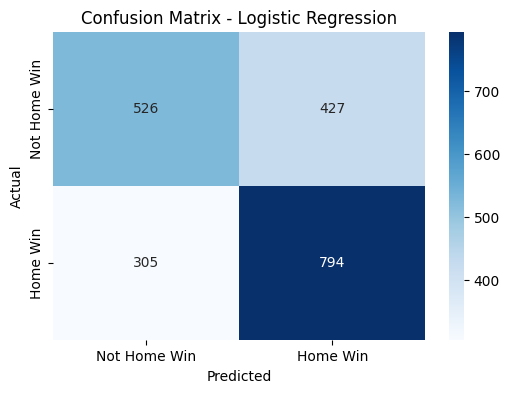

Classification Report:

              precision    recall  f1-score   support

Not Home Win       0.63      0.55      0.59       953
    Home Win       0.65      0.72      0.68      1099

    accuracy                           0.64      2052
   macro avg       0.64      0.64      0.64      2052
weighted avg       0.64      0.64      0.64      2052



In [ ]:
# Import Logistic Regression model
from sklearn.linear_model import LogisticRegression

# Instantiate the model
classifier = LogisticRegression(random_state=0)

# Train the model on the training data
classifier.fit(X_train, y_train)

# Predict the outcomes on the test set
y_pred = classifier.predict(X_test)

# Import evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home Win', 'Home Win'], yticklabels=['Not Home Win', 'Home Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Print detailed classification performance
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Not Home Win', 'Home Win']))


SVM

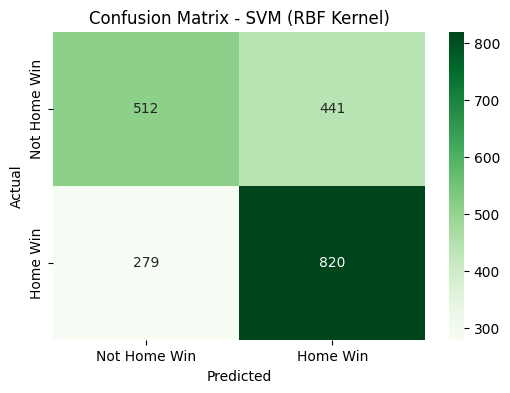

Classification Report:

              precision    recall  f1-score   support

Not Home Win       0.65      0.54      0.59       953
    Home Win       0.65      0.75      0.69      1099

    accuracy                           0.65      2052
   macro avg       0.65      0.64      0.64      2052
weighted avg       0.65      0.65      0.64      2052



In [ ]:
# Import SVM model from scikit-learn
from sklearn.svm import SVC

# Initialize the classifier with RBF kernel
classifier = SVC(kernel='rbf', random_state=0)

# Fit the model on the training data
classifier.fit(X_train, y_train)

# Predict the target values for the test data
y_pred = classifier.predict(X_test)

# Import required metrics
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Home Win', 'Home Win'],
            yticklabels=['Not Home Win', 'Home Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM (RBF Kernel)')
plt.show()

# Print classification metrics
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Not Home Win', 'Home Win']))


Random Forest

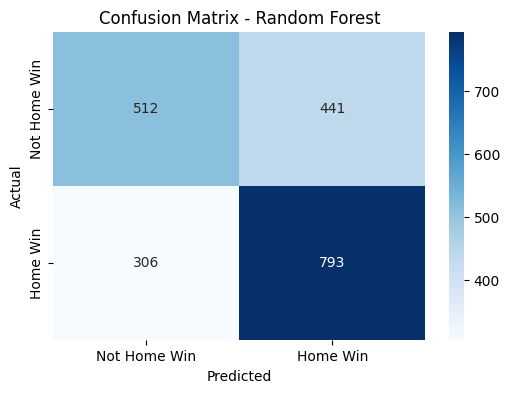

Classification Report:

              precision    recall  f1-score   support

Not Home Win       0.63      0.54      0.58       953
    Home Win       0.64      0.72      0.68      1099

    accuracy                           0.64      2052
   macro avg       0.63      0.63      0.63      2052
weighted avg       0.63      0.64      0.63      2052

Out-of-Bag Score: 63.64%


In [ ]:
# Import Random Forest model
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier with specific hyperparameters
classifier = RandomForestClassifier(
    criterion='gini',               # Splitting quality metric: 'gini' or 'entropy'
    n_estimators=700,              # Number of decision trees in the forest
    min_samples_split=10,          # Minimum samples required to split an internal node
    min_samples_leaf=1,            # Minimum samples required to be a leaf node
    max_features='sqrt',           # Number of features to consider when looking for the best split
    oob_score=True,                # Use out-of-bag samples to estimate generalization accuracy
    random_state=1,                # Seed for reproducibility
    n_jobs=-1                      # Use all CPU cores for parallel training
)

# Fit the classifier to the training data
classifier.fit(X_train, y_train)

# Predict target values for the test data
y_pred = classifier.predict(X_test)

# Import metrics for evaluation
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Home Win', 'Home Win'],
            yticklabels=['Not Home Win', 'Home Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# Print classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Not Home Win', 'Home Win']))

print("Out-of-Bag Score: {:.2f}%".format(classifier.oob_score_ * 100))

XG Boost

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:29:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


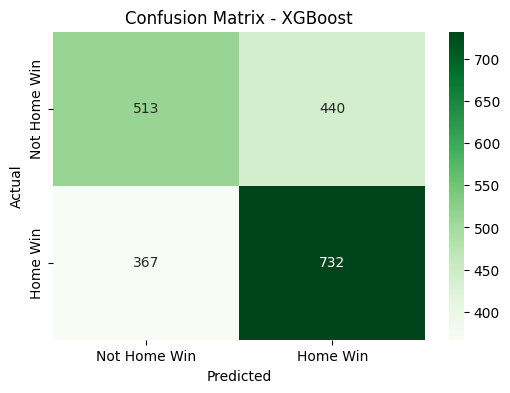

Classification Report:

              precision    recall  f1-score   support

Not Home Win       0.58      0.54      0.56       953
    Home Win       0.62      0.67      0.64      1099

    accuracy                           0.61      2052
   macro avg       0.60      0.60      0.60      2052
weighted avg       0.61      0.61      0.61      2052



In [ ]:
# Import XGBoost classifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Encode target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Initialize the XGBoost model with a random seed
classifier = XGBClassifier(seed=82, use_label_encoder=False, eval_metric='mlogloss')  # Prevents warning

# Fit the model to the training data
classifier.fit(X_train, y_train_encoded)

# Predict on the test data
y_pred_encoded = classifier.predict(X_test)

# Decode predictions back to original labels for evaluation
y_pred = le.inverse_transform(y_pred_encoded)


# Import evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Home Win', 'Home Win'],
            yticklabels=['Not Home Win', 'Home Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# Display classification metrics
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Not Home Win', 'Home Win']))

Compare All Models Side-by-Side


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Encode target variable for XGBoost
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


models = {
    "Logistic Regression": LogisticRegression(random_state=0),
    "SVM (RBF Kernel)": SVC(kernel='rbf', random_state=0),
    "Random Forest": RandomForestClassifier(criterion='gini',
                                            n_estimators=700,
                                            min_samples_split=10,
                                            min_samples_leaf=1,
                                            max_features='sqrt', # Changed from 'auto' to 'sqrt'
                                            oob_score=True,
                                            random_state=1,
                                            n_jobs=-1),
    "XGBoost": XGBClassifier(seed=82, use_label_encoder=False, eval_metric='mlogloss')
}

results = {}

for name, model in models.items():
    # Check if the model is XGBoost and use encoded target
    if name == "XGBoost":
        model.fit(X_train, y_train_encoded)
        preds_encoded = model.predict(X_test)
        preds = le.inverse_transform(preds_encoded) # Decode predictions for accuracy calculation
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    results[name] = acc

# Show results
print("Model Comparison (Accuracy %):")
for model, score in results.items():
    print(f"{model}: {score * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:30:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Comparison (Accuracy %):
Logistic Regression: 64.33%
SVM (RBF Kernel): 64.91%
Random Forest: 63.60%
XGBoost: 60.67%


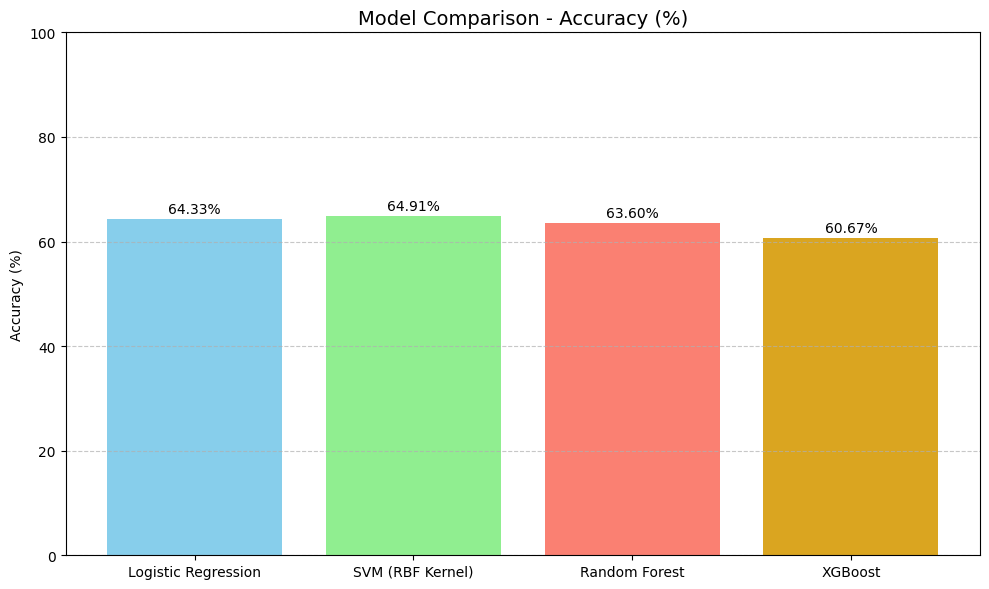

In [ ]:
import matplotlib.pyplot as plt

# Plotting the model comparison results
model_names = list(results.keys())
accuracy_scores = [score * 100 for score in results.values()]  # Convert to percentages

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracy_scores, color=['skyblue', 'lightgreen', 'salmon', 'goldenrod'])

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom')

plt.title('Model Comparison - Accuracy (%)', fontsize=14)
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
